In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
print(train.shape)

(891, 12)


In [3]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=["Train"])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


In [4]:
train.pop("Cabin")
train.pop("Name")
train.pop("Ticket")

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [5]:
# Filling missing Age values with mean
train["Age"] = train["Age"].fillna(train["Age"].mean())

In [7]:
# Filling missing Embarked values with most common value
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

In [8]:
train["Pclass"] = train["Pclass"].apply(str)

In [9]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == "object"].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [10]:
labels = train.pop("Survived")

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
y_pred = rf.predict(x_test)

In [14]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.78249791144528

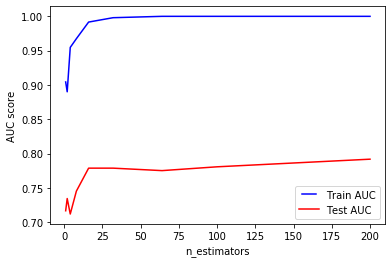

In [17]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()